### For the analysis of the reduced Crab Nebula data

The point of this analysis is to follow the protocol outlined in the draft of the paper. In the second draft of the paper, I state that there are two objectives for the analysis:  
1. Estimate the flux from the pulsar  
  * For this estimate, it would be useful to subtract the flux from the nebula, to only get the flux from the pulsar. Estimates will be made using each filter. It may be useful to isolate the section of the image containing the pulsar


2. Estimate the flux from the nebula
  * For this estimate, first the stars that we dont want as part of the nebula must be subtracted. 
    * It may be possible to do this by getting their contribution to a PSF model and then subtracting it from the overall image. This will leave only the contributions from the Nebula itself.
  * Nextr it will be necessary to create a second model that estimates the size of the nebula assuming an elliptical distribution.
    * It may be possible to this by adding paramters to the PSF function. Check 324 lecture "Maximum Likelihood Estimators"
  * Use the estimate of the flux to get the sizes of different parts of the nebula?  
    
    
3. Lastly each of the above will need to be done for all of the filters  


In [1]:
import numpy as np
from photutils import datasets
from astropy.io import fits

import glob
import matplotlib.pyplot as plt

In [69]:
def showImage(data, vMin = 5, vMax = 99.7):
    """
    Real quick funciton to plot any data. 
    """
    plt.figure(figsize = (12, 12))
    plt.imshow(data, vmin=np.percentile(data, vMin), vmax=np.percentile(data, vMax),
                origin='lower', cmap='viridis', interpolation='nearest')

In [3]:
images = glob.glob('data/CrabData/reduced/reduced2*.fits') # Grab all of the reduced data
images

['data/CrabData/reduced/reduced2_SDSS i.0002.fits',
 'data/CrabData/reduced/reduced2_zCrab.0001.fits',
 'data/CrabData/reduced/reduced2_SDSS g#2.0001.fits',
 'data/CrabData/reduced/reduced2_zCrab.0000.fits',
 'data/CrabData/reduced/reduced2_SDSS r#2.0001.fits',
 'data/CrabData/reduced/reduced2_SDSS g#2.0002.fits',
 'data/CrabData/reduced/reduced2_SDSS g#2.0000.fits',
 'data/CrabData/reduced/reduced2_SDSS i.0000.fits',
 'data/CrabData/reduced/reduced2_SDSS i.0001.fits',
 'data/CrabData/reduced/reduced2_SDSS r#2.0003.fits',
 'data/CrabData/reduced/reduced2_SDSS r#2.0000.fits',
 'data/CrabData/reduced/reduced2_SDSS r#2.0002.fits']

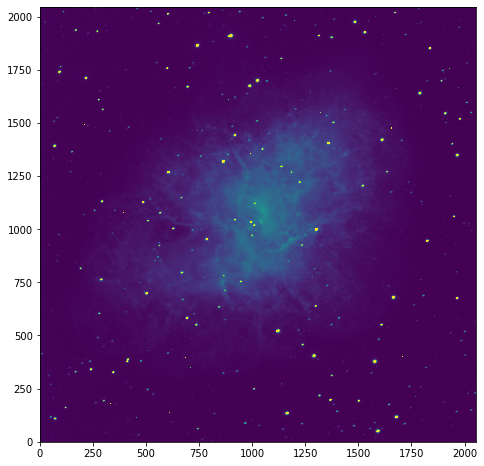

In [4]:
data = fits.getdata(images[2]).astype(float) # Get the data from the fits as floats so there are no issues with negatives
showImage(data)

Comparison of the above image illustrates that the crab pulsar is the right hand star of the pair located in the center of nebula. Isolating those two:

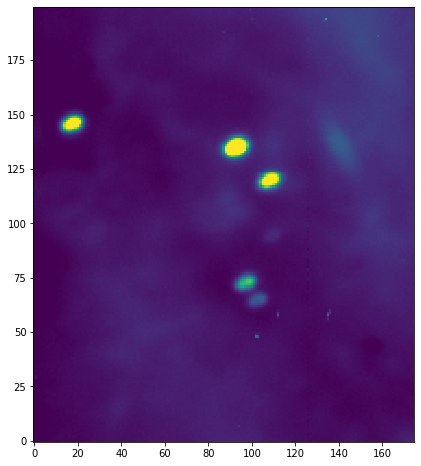

In [5]:
showImage(data[900:1100, 900:1075])

Because the pulsar is embedded in the nebula, if we would like to estimate it's flux, then the true background of the image in addition to flux from the nebula must all be removed. This then is easy because these two contributions can be approximated as the backgound, subtracted and the result will be only the flux from the pulsar.  


Using a point spread function means fitting the distribution of a star to a function to obtain an estimate of the flux (The function which is fit can either be created in astropy from "building an effective PSF" or by simply using one of the built in functions). For this reason this method will have a glaring issue when used on stars in the nebula: the nebula contributes to the flux in a given region containing a star. So the model would then be fit to the nebular flux as well! This problem can be well accounted for by using annulr photometry. 

Perhaps the best method would be to come up with a PSF, then estimate the flux of the star in the background using annular photometry, finally subtract the flux from the background stars by usuing the estimate of the flux in the PSF to subtract that amount from the regions containing those sources in the nebula. 

### Step 1: Estimating the flux of the pulsar:

Progress Ladder: 
  1. Identify the pulsar
  2. Estimate the background
    * Background contains the actual background plus the flux from the nebula... how to get the nebula contribution?
      * Get Nebula contribution from other methods? 2D background ewtimation or image segmentation?
  3. Determine the appropriate size for the distribution of the pulsar/star
    * Try creating a plot of the radius versus the flux captured, estimate the radius that way.
  4. Estimate the flux of the pulsar 
    * Does this require anything special? 
      * Could build a PSF from other stars in the image, get background from above then get flux that way?  
  5. Use the flux measurements to get magnitudes in each of the filters. 
  5. Re-factor everything and functionate the proccesses so that they can easily be applied to all of the images.

#### 1 Identify the pulsar:

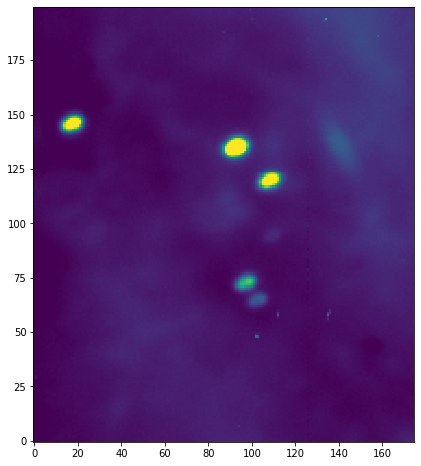

In [6]:
showImage(data[900:1100, 900:1075]) # Zoom in on the pulsar, again

Looks Good!

#### 2 Estimate the background:

We can either use annulus photometry which will maybe give a good result OR 2d background estimation, subtract that result from the image, and then use a PSF to get the flux that way.

I am choosesing to use 2d Background estimation as I think that because the nebula flux is a factor, using this method might return a better result given that the flux from the nebula is different across the entire image. 

Will this method give a better result than annulus photometry? Who Knows!!

In [7]:
from astropy.stats import SigmaClip
from photutils import Background2D, MedianBackground, SExtractorBackground, BiweightLocationBackground

pulsar  = data[900:1100, 900:1075] # Name the pulsar data

sigmaClip = SigmaClip(sigma = 3) # initialize the sigma clipping object
bkgEstimator = SExtractorBackground(sigmaClip) # initialize the background estimation object
bkg = Background2D(pulsar, (20, 25), filter_size=(3, 3), sigma_clip = None, bkg_estimator=bkgEstimator) # Call the 2D background estimation function



From the docs: _"Box size should be chosen to be larger than the sources and smaller than variations in the background"_

Below I try and estimate the size of the sources  as well as the FWHM.
The `filter_size` refers to the window size for median filtering after the background estimation is complete. 

Given that I am using this to try and subtract the nebula from the image, it is unlikely that I will find a perfect box_size. Without doubt there are variations in the background that are smaller than 20x25 pixels, but making the box_size smaller than this means that some of the sources are included.

3914.898142201056
185.99293649679868


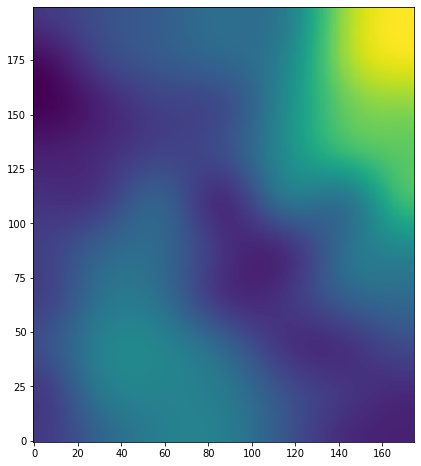

In [8]:
print(bkg.background_median)  
print(bkg.background_rms_median)  
plt.figure(figsize = (8, 8))
plt.imshow(bkg.background, origin = 'lower', cmap = 'viridis') # Plots the background image. 

Now all that's left is to subtract the background from the image. 

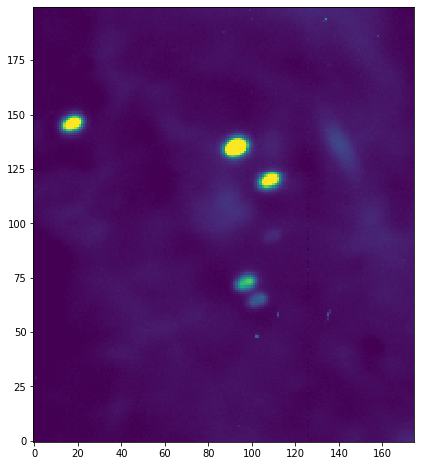

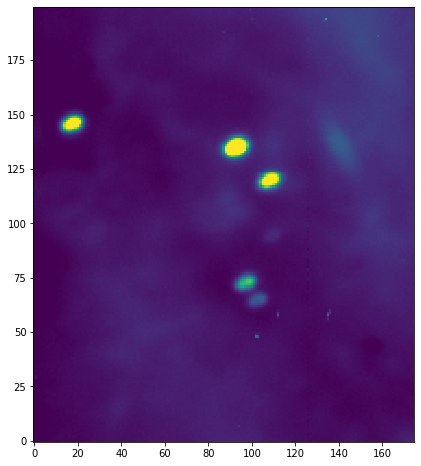

In [9]:
reducedPulsar = pulsar - bkg.background
showImage(reducedPulsar)
showImage(pulsar)

#### 3 Determine the appropriate size for the pulsar: 
Estimating the correct aperture size of our stars. There are a few things to consider here. One is that some of the functions implemented in the photutils package rely on aperture radius while other rely on FWHM. On can be obtained from the other, but they aren't the same thing. StarFinder relies on FWHM while the Photometry functions rely on radii. For this reason both of these quanities are important to find.

I will start by trying to find the appropriate radius for the photometry: 

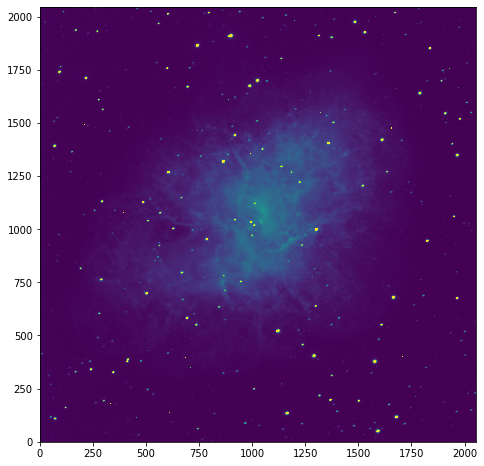

In [10]:
showImage(data)

Now I want to grab some stars well away from the nebula. Say the upper right corner

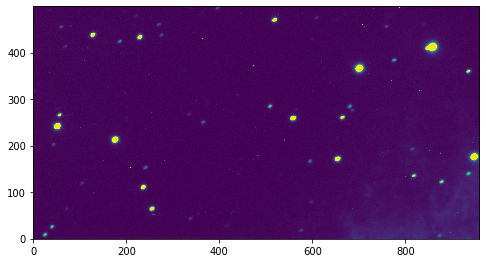

In [11]:
radiusData = data[1500:2000, 40:1000] # Select the upper right stars to estimate the radius and FWHM from. 
showImage(radiusData)

Now I can use a rudimentary search do identify the centroid. 

For this image, It is apporpriate to use sigma clipping to remove the sources and estimate the background as the mean since there is no nebular flux to contend with

In [12]:
from astropy.stats import sigma_clipped_stats

mean, median, std = sigma_clipped_stats(radiusData, 
                                        sigma=3) # estimate the background using sigma clipping and median
print((mean, median, std))  

(1137.2800421471102, 1133.296485528734, 34.59820769883886)


In [13]:
from photutils import DAOStarFinder
daofind = DAOStarFinder(fwhm=10.0, threshold=100.*std) # initialize the starfinder object
sources = daofind(radiusData - median) #call starfinder playing with the parameters returns more or less stars

In [14]:
print(sources)

 id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 25.382216330234847 ... 2.6705019536656502  -1.0664822500578734
  2 40.646327591052504 ...  2.612894546791734  -1.0428047062255024
  3 255.14634616382182 ...   8.96329788972077  -2.3811695754356164
  4 236.43630375497926 ...  11.22790486871609  -2.6257468107684274
  5  877.3918200631466 ... 2.8453975433214813  -1.1353573805266346
  6  817.5905939911937 ... 3.2316308167168306  -1.2735543522391373
  7  935.0452036111623 ...  2.328180231909231  -0.9175414935247963
  8 241.29449335008957 ... 1.1067745598552519 -0.11014791989865548
  9   594.630065338684 ... 1.1281206305494649 -0.13088885368586173
 10  653.9418250768248 ...  25.97282383717867   -3.536297924731182
...                ... ...                ...                  ...
 17 56.664471786043755 ...  5.291562122276007  -1.8089597476382075
 18  680.1060298510157 ... 1.7772359540475333  -0.624362726432

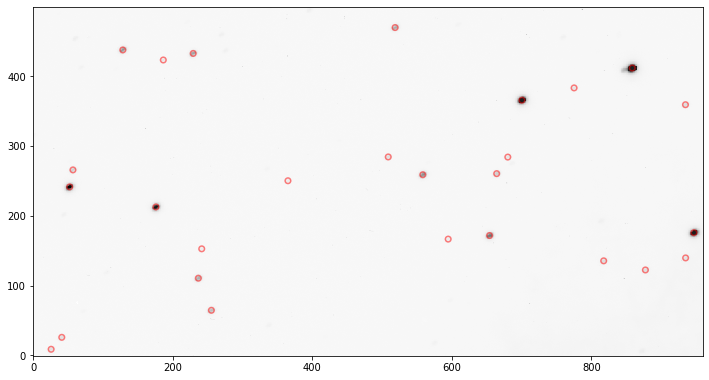

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture


positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.)
norm = ImageNormalize(stretch=SqrtStretch())
plt.figure(figsize = (12, 12))
plt.imshow(radiusData, cmap='Greys', origin='lower', norm=norm)
apertures.plot(color='r', lw=1.5, alpha=0.5) # Big long cell, plots things, don't know what stretching is :/ 

Now we have identified the star we want. It is the fourth star in the list. Now I can create a plot of the flux as a function of the radius and see how large of a radius is required. 

In [17]:
from photutils import aperture_photometry, CircularAperture 

appSize = np.arange(1, 41, 1) # Create array of appertures to test
fluxs = np.zeros((len(sources) ,40)) # Create array to store calculated fluxs.

for j, pos in enumerate(positions): # Single out the star we want to get the flux from
    for i in appSize:
        apertures = CircularAperture(pos, r=i)  # Create the apperture
        fluxs[j, i - 1] = aperture_photometry(radiusData - median, # This uses the median subtracted image, things are weird if you use the unsubtracted iamge
                                           apertures)['aperture_sum'] # Get the aperture sum from the given aperture


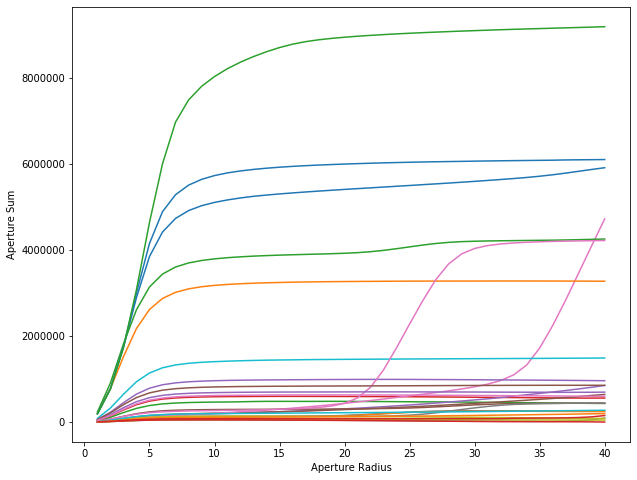

In [18]:
plt.figure(figsize = (10, 8))
for i in range(len(sources)):
    plt.plot(appSize, fluxs[i])

plt.xlabel('Aperture Radius');
plt.ylabel('Aperture Sum');
# plt.savefig('apRadiusandFlux.png')

The above proves that stars with different fluxs will have the same width distribution (so the same PSF). This is evident becasue the elbows of all of the curves above occur at the same rate in the same area. 


Now I want to get the FWHM. To do this I am wondering if it is more appropriat to marginalize a source over the two axis or to grab a single strip of pixels crossing the centroid and plot those. 

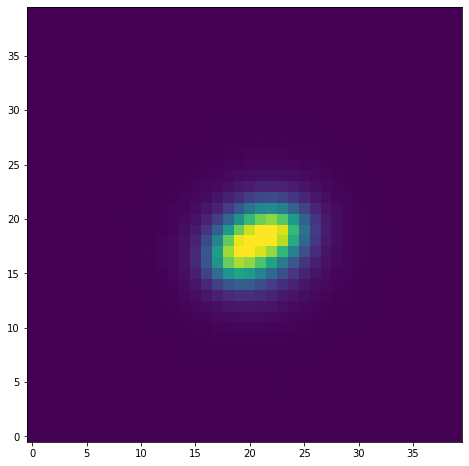

In [19]:
fwhmData = radiusData[195:235, 155:195] # whoopsies, better choose a new star!
showImage(fwhmData)

Text(0, 0.5, 'Summed Count')

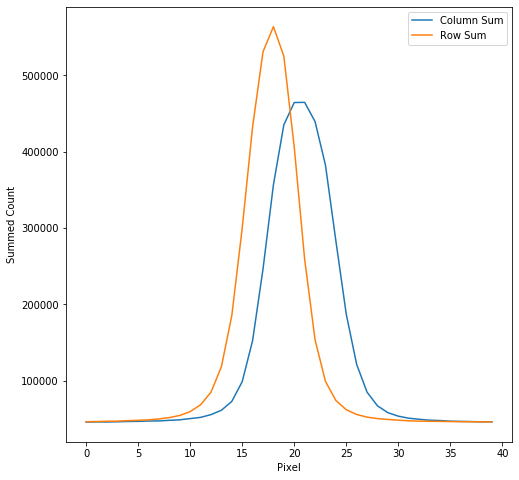

In [20]:
x = np.arange(0, 40, 1)

colSum = np.sum(fwhmData, axis = 0)
rowSum = np.sum(fwhmData, axis = 1)


plt.figure(figsize = (8, 8))
plt.plot(x, colSum, label = 'Column Sum')
plt.plot(x, rowSum, label = 'Row Sum')
plt.legend()
plt.xlabel('Pixel')
plt.ylabel('Summed Count')

With this knowledge now I can better approximate the appropriate size cells for the 2DBackground estimation OR the appropriate radius of the aperture and annulus for the annulus approximation methods.


With that in mind, and the knowledge that the radius of the sources is about 7 pixels, each source is roughly a circle of diameter 14. So the cells must be AT LEAST 14x14. I will choose to use cells of 20x25 because the size of the image that I have removed from the data to estimate the pulsar is about that big. 

#### 4. Estimate the flux of the pulsar 

There are a few ways to do this. I could use __annulus photometry__ on:
  1. The 2DBackground reduced image, estimating the background a second time.
  2. The raw image, not estimating the background again.
  
I could also use __PSF Photometry__. To do this I would first build a model based on the building a PSF thing in the docs, then apply this model to the x and y centroid found from the starfinder search. The model would need to be applied to the reduced image (I think, I am less sure about how this method would work).
  1. Create an ePSF so that the PSF we end up using actually matches the data that we have. Using a guassian gives wierd results since our things aren't circular :/
  2. Now use the ePSF to do PSF photometry. You will have a few choices to make here:
    * You can choose to estimate the background as 2DBackground. 
    * Or you can estimate the background using the median estimation technique.
    * Don't really know which one is going to be better

In [21]:
# Use DAO Starfinder to get the position of the pulsar

mean, median, std = sigma_clipped_stats(pulsar, 
                                        sigma=3) # Simple approximation suffices for identifying the stars
daofind = DAOStarFinder(fwhm=10.0, threshold=50.*std) # initialize the starfinder object
sources = daofind(pulsar - median) #call starfinder playing with the parameters returns more or less stars
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,108.41618175780806,119.9032856494555,0.4219389958451286,0.29518210299103786,-0.4277645238800841,169,0.0,15270.817580314559,1.977064868596042,-0.7400522974763079
2,92.8489743227539,135.14990979973322,0.4277896850004937,0.32506640241026913,-0.3561564705002695,169,0.0,32379.70249717313,4.174309958818519,-1.5514617349708035
3,17.76239733107912,145.9912355049554,0.44517817149280126,0.3254076339431503,-0.3400717281976561,169,0.0,15468.5323851124,2.0651593454746364,-0.7873839174513558


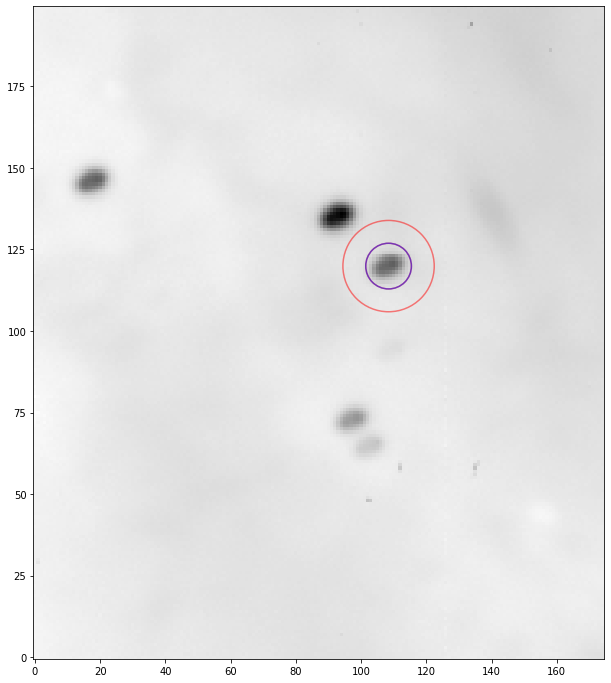

In [22]:
from photutils import CircularAnnulus
 
pulsarPos = np.transpose((sources['xcentroid'][0], sources['ycentroid'][0])) # Grab just the pulsar

aperture = CircularAperture(pulsarPos, r = 7) # Create a circular aperture to do photometry inside of
annuluss = CircularAnnulus(pulsarPos, r_in = 7, r_out = 14) # Looking at graph these seem good. Now overlap with other stars, etc

norm = ImageNormalize(stretch=SqrtStretch())
plt.figure(figsize = (12, 12))
plt.imshow(pulsar, cmap='Greys', origin='lower', norm=norm)
annuluss.plot(color='r', lw=1.5, alpha=0.5) # Big long cell, plots things, don't know what stretching is :/ 
aperture.plot(color = 'b', lw = 1.5, alpha = 0.5)

One thing to note here is that the stars we're interested in seem to be more than 50 sigma above the average but the features of the nebula are less so. This sets a lower level on the amount of sigma clipping needed to trim out the nebula. 

Further more there are methods for elliptical apertures, so this may be more appropriate. 


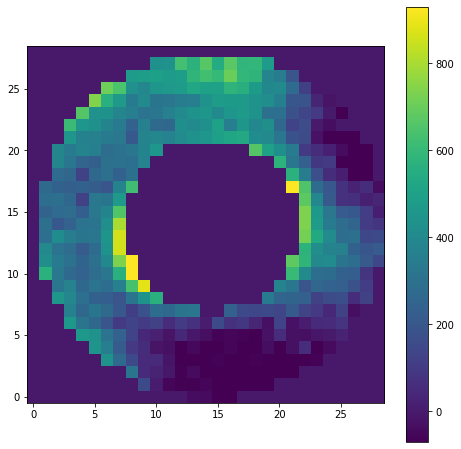

In [24]:
# Begin by using annulus photometry. 

annulus_mask = annuluss.to_mask(method='center') #  Get a mask that only select the annulus
annulus_data = annulus_mask.multiply(reducedPulsar) # Get the values of the data inside the annulus

showImage(annulus_data)
plt.colorbar()

In [25]:
mask = annulus_mask.data
annulus_data_1d = annulus_data[mask > 0] # Get only the values from the annuls, not all of the 0's
annulus_data_1d.shape

(464,)

In [26]:
_, annMedian, _ = sigma_clipped_stats(annulus_data_1d, sigma = 50) # Including extra large values to account for nebula flux
background = annMedian * aperture.area # Multiply the median by the area of the aperture
print(annMedian, background)

277.8671863288141 42774.33005096916


In [29]:
annPhot = aperture_photometry(pulsar, aperture)
annPhot['annulus_median'] = annMedian
annPhot['aperture_bkg'] = background
annPhot['apSum - bkg'] = annPhot['aperture_sum'] - background # remove the background from the sum from the aperture
annPhot

id,xcenter,ycenter,aperture_sum,annulus_median,aperture_bkg,apSum - bkg
,pix,pix,,,,
int64,float64,float64,float64,float64,float64,float64
1,108.41618175780806,119.9032856494555,1391706.0928536942,277.8671863288141,42774.33005096916,1348931.762802725


That concludes the annulus photometry method on the regular data. I'm gonna now try and do the same thing on the already reduced data, `reducedPulsar`. First though it makes sense to define a function to do the above so that it can just be called on the other data. 

In [30]:
# This function is going to take the data, the annuls object and the aperture object
def annulusPhotometry( data,  aperture, annulus, sigma = 3):
    """
    There are certain choices to make about stuff like, sigma clipping
    """
    annulus_mask = annulus.to_mask(method = 'center') # Create a mask of hte annulus

    

    annulus_data = annulus_mask.multiply(data) # Get the data values in the annulus
    annulus_data_1d = annulus_data[annulus_mask.data >  0] # Get a 1D array of anly the values in the annulus
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d, sigma = sigma)
    
    phot = aperture_photometry(data, aperture) # get the apperture sum inside the apperture
    phot['annulus_median'] = median_sigclip
    phot['aper_bkg'] = median_sigclip * aperture.area
    phot['aper_sum_bkgsub'] = phot['aperture_sum'] - phot['aper_bkg']
    
    return phot # Returns the table with all the important stuff in it. 

In [35]:
reducedData_phot = annulusPhotometry(reducedPulsar, aperture, annuluss)
reducedData_phot

id,xcenter,ycenter,aperture_sum,annulus_median,aper_bkg,aper_sum_bkgsub
,pix,pix,,,,
int64,float64,float64,float64,float64,float64,float64
1,108.41618175780806,119.9032856494555,767658.1443819655,277.3731990701681,42698.286620575425,724959.85776139


In [36]:
pulsarData_phot = annulusPhotometry(pulsar, aperture, annuluss)
pulsarData_phot

id,xcenter,ycenter,aperture_sum,annulus_median,aper_bkg,aper_sum_bkgsub
,pix,pix,,,,
int64,float64,float64,float64,float64,float64,float64
1,108.41618175780806,119.9032856494555,1391706.0928536942,4270.4754173096335,657388.6157194318,734317.4771342624


In [42]:
type(reducedData_phot)

astropy.table.table.QTable

In [43]:
from astropy.table import vstack

vstack([reducedData_phot, pulsarData_phot])

id,xcenter,ycenter,aperture_sum,annulus_median,aper_bkg,aper_sum_bkgsub
,pix,pix,,,,
int64,float64,float64,float64,float64,float64,float64
1,108.41618175780806,119.9032856494555,767658.1443819655,277.3731990701681,42698.286620575425,724959.85776139
1,108.41618175780806,119.9032856494555,1391706.0928536942,4270.4754173096335,657388.6157194318,734317.4771342624


Dope dope dope. Now you know how to get the annulus photometry estimates for many things and then combine the outputs of the above function so that you can have one function that combines many things. Take note that the above two estimtes of the flux of the pulsar are within 10,000 counts of each other with the one that used _two_ background subtractions being somewhat less than the one that only used one. 


#### PSF estimate of the flux of the star
The next thing to do then is to generate an ePSF to estimate the flux that way. 

In [239]:
# Firt get a sample of bright stars:
fndpksD = data[10:2040, 10:2040]
fndpksD[100:1750, 225:1750] = 0 # Mask the nebula so that it isn't identified as a peak

from photutils import find_peaks



peaks_tbl = find_peaks(fndpksD, threshold=10000.)  # Not sure how this threshold thing works
peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output  
psfPos = np.transpose((peaks_tbl['x_peak'], peaks_tbl['y_peak'])) # Grab the x an dy values so the stars can be plotted
print(peaks_tbl)
print()

x_peak y_peak peak_value
------ ------ ----------
   246     12  28767.543
  1577     38  70657.831
  1579     38  71060.048
  1580     40  71002.118
  1576     41   70774.93
  1584     41  71124.034
  1581     42  70780.214
  1584     43  70676.086
  1580     44  70472.032
  1582     44  70594.663
   ...    ...        ...
  1762   1952  13304.593
   550   1961  15720.264
  1473   1967  67979.495
  1475   1968  67881.315
  1472   1969  67916.042
  1188   1973  64525.489
   816   1986  64782.759
  2010   1995  10971.343
   594   2005  22661.135
   785   2011  15226.013
  1662   2011  14081.941
Length = 90 rows



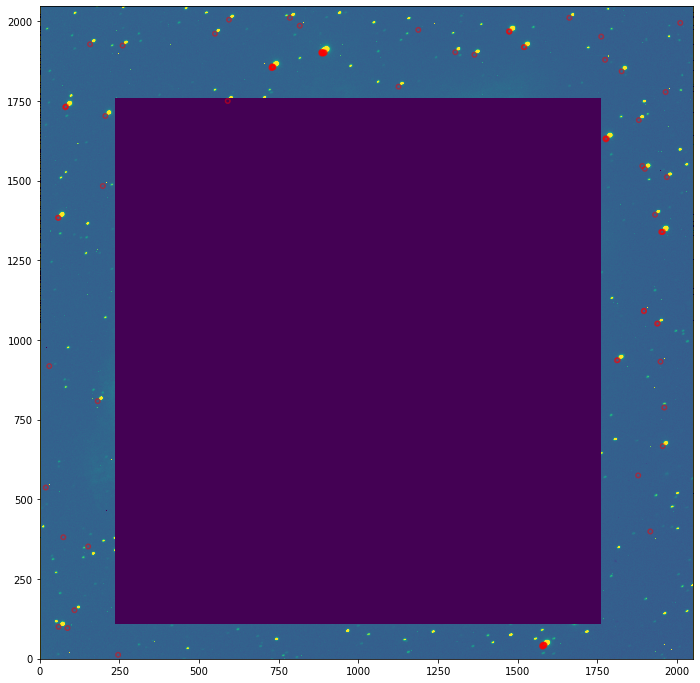

In [240]:
epsfAp = CircularAperture(psfPos, r = 7)
norm = ImageNormalize(stretch=SqrtStretch())

showImage(data)
epsfAp.plot(color='r', lw=1.5, alpha=0.5) # Plot hte stars found

In [241]:
psfPos

array([[ 246,   12],
       [1577,   38],
       [1579,   38],
       [1580,   40],
       [1576,   41],
       [1584,   41],
       [1581,   42],
       [1584,   43],
       [1580,   44],
       [1582,   44],
       [  87,   96],
       [  59,  100],
       [ 109,  152],
       [ 152,  352],
       [  74,  381],
       [1916,  399],
       [  19,  537],
       [1878,  575],
       [1955,  667],
       [1960,  788],
       [ 182,  808],
       [  30,  918],
       [1948,  932],
       [1811,  936],
       [1814,  937],
       [1937, 1051],
       [1940, 1052],
       [1896, 1090],
       [1896, 1092],
       [1950, 1339],
       [1952, 1339],
       [1954, 1339],
       [1956, 1340],
       [  59, 1383],
       [  57, 1384],
       [1931, 1393],
       [ 198, 1483],
       [1968, 1511],
       [1899, 1537],
       [1891, 1546],
       [1777, 1629],
       [1775, 1631],
       [1780, 1632],
       [1776, 1633],
       [1880, 1690],
       [ 206, 1703],
       [  80, 1730],
       [  81,

Now I need to clean it. First I need all of the x values

In [259]:
xs = psfPos[:, 0]

poop = []
for i, a in enumerate(psfPos[:, 0]): 
    for j, alsoa in enumerate(psfPos[:, 0]):
        res = np.abs(a - alsoa)
        if res < 25:
            poop.append([i, j])

In [260]:
poop

[[0, 0],
 [0, 77],
 [1, 1],
 [1, 2],
 [1, 3],
 [1, 4],
 [1, 5],
 [1, 6],
 [1, 7],
 [1, 8],
 [1, 9],
 [2, 1],
 [2, 2],
 [2, 3],
 [2, 4],
 [2, 5],
 [2, 6],
 [2, 7],
 [2, 8],
 [2, 9],
 [3, 1],
 [3, 2],
 [3, 3],
 [3, 4],
 [3, 5],
 [3, 6],
 [3, 7],
 [3, 8],
 [3, 9],
 [4, 1],
 [4, 2],
 [4, 3],
 [4, 4],
 [4, 5],
 [4, 6],
 [4, 7],
 [4, 8],
 [4, 9],
 [5, 1],
 [5, 2],
 [5, 3],
 [5, 4],
 [5, 5],
 [5, 6],
 [5, 7],
 [5, 8],
 [5, 9],
 [6, 1],
 [6, 2],
 [6, 3],
 [6, 4],
 [6, 5],
 [6, 6],
 [6, 7],
 [6, 8],
 [6, 9],
 [7, 1],
 [7, 2],
 [7, 3],
 [7, 4],
 [7, 5],
 [7, 6],
 [7, 7],
 [7, 8],
 [7, 9],
 [8, 1],
 [8, 2],
 [8, 3],
 [8, 4],
 [8, 5],
 [8, 6],
 [8, 7],
 [8, 8],
 [8, 9],
 [9, 1],
 [9, 2],
 [9, 3],
 [9, 4],
 [9, 5],
 [9, 6],
 [9, 7],
 [9, 8],
 [9, 9],
 [10, 10],
 [10, 12],
 [10, 14],
 [10, 46],
 [10, 47],
 [10, 48],
 [11, 11],
 [11, 14],
 [11, 33],
 [11, 34],
 [11, 46],
 [11, 47],
 [11, 48],
 [12, 10],
 [12, 12],
 [13, 13],
 [13, 78],
 [14, 10],
 [14, 11],
 [14, 14],
 [14, 33],
 [14, 34],
 [14, 46],

In [266]:
psfnew = np.copy(psfPos)
poop = np.array(poop)
for a in poop[:, 1]:
    psfnew[a, :] = 0

In [267]:
 psfnew

array([[0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0,